# Append GHSL data

In [32]:
import pandas as pd
import geopandas as gp
import os

In [33]:
df = pd.read_csv('./sample_data/02_metadata_common_attributes.csv')
df = df[['uuid', 'source', 'orig_id', 'lat', 'lon']]
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   uuid     2319 non-null   object 
 1   source   2319 non-null   object 
 2   orig_id  2319 non-null   int64  
 3   lat      2319 non-null   float64
 4   lon      2319 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 90.7+ KB


In [34]:
import rasterio
from rasterio.features import shapes
from rasterio.windows import Window
from rasterio.transform import xy

raster_filename = './ghsl/GHS_SMOD_P2030_GLOBE_R2022A_54009_1000_V1_0.tif'
# visit https://human-settlement.emergency.copernicus.eu/download.php?ds=smod if you wish to download the latest version of GHSL data 

with rasterio.open(raster_filename, 'r') as src:
    T0 = src.transform
    nrow = src.height
    ncol = src.width
    raster = src.read(1)
    dst_crs = src.crs.to_proj4()

print(f"Raster width x height: {ncol} x {nrow}")
print(f"Raster affine transform:")
print(T0)
print(dst_crs)

Raster width x height: 36082 x 18000
Raster affine transform:
| 1000.00, 0.00,-18041000.00|
| 0.00,-1000.00, 9000000.00|
| 0.00, 0.00, 1.00|
+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs=True


In [35]:
import fiona.transform

def reproject_coords(src_crs, dst_crs, xs, ys):
    xs2, ys2 = fiona.transform.transform(src_crs, dst_crs, xs, ys)
    return [[x,y] for x,y in zip(xs2, ys2)]


In [36]:
%%time

xs = df['lon'].tolist()
ys = df['lat'].tolist()
src_crs = 'EPSG:4326'
new_coords = reproject_coords(src_crs, dst_crs, xs, ys)

with rasterio.open(raster_filename, 'r') as src:
    values = list(rasterio.sample.sample_gen(src, new_coords))

CPU times: user 108 ms, sys: 6.49 ms, total: 115 ms
Wall time: 112 ms


In [37]:
values2 = [value[0] for value in values]
df_values = pd.DataFrame(values2)

In [38]:
def urban_code_to_term(value):
    if value == 30:
        return 'urban centre'
    if value == 23:
        return 'dense urban cluster'
    if value == 22:
        return 'semi-dense urban cluster'
    if value == 21:
        return 'suburban or peri-urban'
    if value == 13:
        return 'rural cluster'
    if value == 12:
        return 'low density rural'
    if value == 11:
        return 'very low density rural'
    if value == 10:
        return 'water'

In [39]:
from tqdm.auto import tqdm
tqdm.pandas()
df_values = df_values.rename(columns={0: 'urban_code'})
df_values['urban_term'] = df_values.progress_apply(lambda row: urban_code_to_term(row['urban_code']), axis=1)
df_values.head()

  0%|          | 0/2319 [00:00<?, ?it/s]

,urban_code,urban_term
0,30,urban centre
1,30,urban centre
2,30,urban centre
3,30,urban centre
4,30,urban centre


In [40]:
df_values.isnull().any()

urban_code    False
urban_term    False
dtype: bool

In [41]:
df_values['urban_term'].value_counts()

urban centre    2319
Name: urban_term, dtype: int64

<AxesSubplot:ylabel='urban_term'>

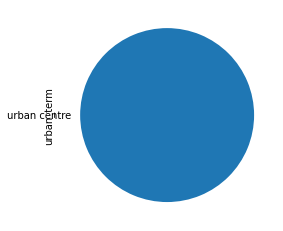

In [42]:
df_values['urban_term'].value_counts().plot(kind='pie')

In [43]:
df_values['urban_term'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

urban centre    100.0%
Name: urban_term, dtype: object

In [44]:
df_ghsl = df[['uuid', 'source', 'orig_id']]
df_ghsl['urban_code'] = df_values['urban_code']
df_ghsl['urban_term'] = df_values['urban_term']
df_ghsl.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uuid        2319 non-null   object
 1   source      2319 non-null   object
 2   orig_id     2319 non-null   int64 
 3   urban_code  2319 non-null   int16 
 4   urban_term  2319 non-null   object
dtypes: int16(1), int64(1), object(3)
memory usage: 77.1+ KB


/var/folders/q9/ztfc9wt509z8qb3p7wtf4_280000gn/T/ipykernel_21350/2468067593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ghsl['urban_code'] = df_values['urban_code']


In [45]:
df_ghsl.to_csv('./sample_data/06_ghsl.csv', index=False)